#  Restaurant Recommender


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


### Yelp data from last 2 years in Las Vegas

In [2]:
df = pd.read_csv('last_2_years_restaurant_reviews.csv')

In [126]:
df.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,name,categories,avg_stars
0,--9e1ONYQuAa-CB_Rrw7Tw,1,2016-05-17,0,0Qc1THNHSapDL7cv-ZzW5g,5,What can I say.. Wowzers! Probably one of the ...,0,4LxKRRIikhr65GfPDW626w,Delmonico Steakhouse,"['Steakhouses', 'Cajun/Creole', 'Restaurants']",4.0
1,--9e1ONYQuAa-CB_Rrw7Tw,0,2017-01-20,0,L8lo5SKXfZRlbn1bpPiC9w,5,Went here for guys weekend. Unbelievable. Ravi...,0,nT8zgjoc-PbdBoQsFEXFLw,Delmonico Steakhouse,"['Steakhouses', 'Cajun/Creole', 'Restaurants']",4.0
2,--9e1ONYQuAa-CB_Rrw7Tw,52,2016-09-25,30,6eUT3IwwWPP3CZkAhxqOIw,5,"One word my friends: tableside!!! Yes, tablesi...",56,7RlyCglsIzhBn081inwvcg,Delmonico Steakhouse,"['Steakhouses', 'Cajun/Creole', 'Restaurants']",4.0


# Get Ratings data 

#### Select relevant columns in the original dataframe

In [3]:
# Get business_id, user_id, stars for recommender
df_stars = df[['business_id', 'user_id', 'stars']]
print 'number of users:',df_stars['user_id'].nunique(),'  number of business ID:',df_stars['business_id'].nunique()

number of users: 203220   number of business ID: 5981


# Data Exploratory Analysis

### create a dataframe to present the average ratings and the number of reviews for each business_id and 

In [4]:
ratings=pd.DataFrame(df.groupby('business_id')['stars'].mean())
ratings['business_id']=ratings.index
ratings['num of ratings given by users'] = pd.DataFrame(df.groupby('business_id')['stars'].count())

### merge with the orignial dataframe to get the restaurant name

In [5]:
result=ratings.merge(df, on=['business_id'], how='left')
ratings=result[['business_id','stars_x','num of ratings given by users','name']]
ratings=ratings.rename(columns=({'stars_x':'stars'}))
ratings_final=ratings.drop_duplicates()

### Now I can check info by restaurant name

In [8]:
ratings_final[ratings_final['name']=='Mon Ami Gabi'] # my favoriate one in Vegas!

,business_id,stars,num of ratings given by users,name
40682,4JNXUYY8wbaaDmk3BPzlWw,4.112854,2614,Mon Ami Gabi


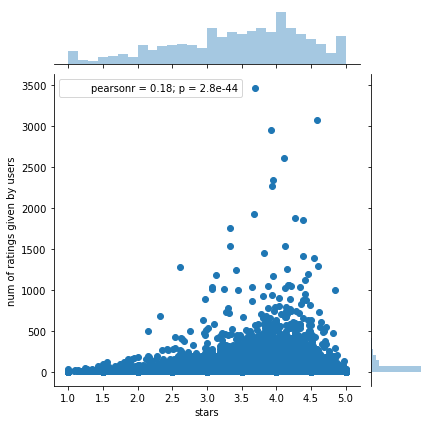

In [59]:
sns.jointplot(x='stars',y='num of ratings given by users',data=ratings_final) 

### The distributions of num of ratings: it looks most restaurants received low number of ratings

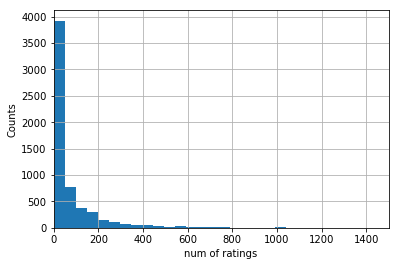

In [6]:
axes = plt.gca()
axes.set_xlim([0,1500])
ratings_final['num of ratings given by users'].hist(bins=70)
plt.xlabel('num of ratings')
plt.ylabel('Counts')

###  The distributions of Ratings 

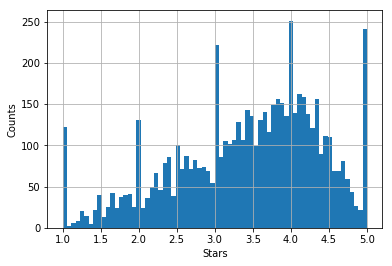

In [10]:
ratings_final['stars'].hist(bins=70)
plt.xlabel('Stars')
plt.ylabel('Counts')

#### I see a spike at stars==5 and wondering how many times each those restaurants have been rated. 

In [58]:
ratings_final[ratings_final['stars']==5]['num of ratings given by users'].mean()

3.9273504273504272

# Data Flitering

### Check how many reviews each user_id gives. 
it looks a large amount of users give very few reviews. >60% gives 1 reviews


In [30]:
df_user_counts = df_stars['user_id'].value_counts()
float(df_user_counts[df_user_counts > 5].count())*100/df_stars['user_id'].nunique()

6.770002952465308

### Check how many users give > 5 reviews 

In [31]:
df_users = df_user_counts[df_user_counts > 5] 
df_stars_cleaned = df_stars.set_index('user_id').loc[df_users.index].reset_index()

### Check how many reviews each restaurant has received. 

select the business_id has received > 5 reviews. 

In [34]:
df_business_counts = df_stars_cleaned['business_id'].value_counts()
# select the business_id have received > 5 reviews 
df_business = df_business_counts[df_business_counts > 5]
df_stars_cleaned = df_stars_cleaned.set_index('business_id').loc[df_business.index].reset_index()

In [37]:
print 'number of users (give >5 times reviews):',df_stars_cleaned['user_id'].nunique(), '  number of business ID (> 5 times reviewed):',df_stars_cleaned['business_id'].nunique()

number of users (give >5 times reviews): 13758   number of business ID (> 5 times reviewed): 3857


### Now compare the distributions of ratings: original all business_id vs filtered business_id (>5 reviews)

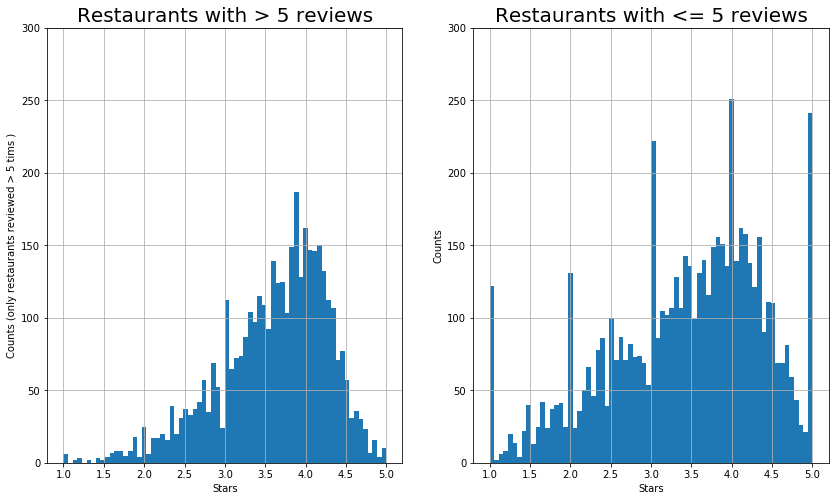

In [38]:
ratings_filtered=pd.DataFrame(df_stars_cleaned.groupby('business_id')['stars'].mean())
plt.figure(figsize=(14,8))

plt.subplot(1,2,1)
axes = plt.gca()
axes.set_ylim([0,300])
ratings_filtered['stars'].hist(bins=70)
plt.xlabel('Stars')
plt.ylabel('Counts (only restaurants reviewed > 5 tims )')
plt.title ('Restaurants with > 5 reviews', fontsize=20)

plt.subplot(1,2,2)
axes = plt.gca()
axes.set_ylim([0,300])
ratings_final['stars'].hist(bins=70)
plt.xlabel('Stars')
plt.ylabel('Counts')
plt.title ('Restaurants with <= 5 reviews', fontsize=20)

# Create utility matrix 

In [39]:
df_utility = pd.pivot_table(df_stars_cleaned, values = 'stars', index = 'user_id', columns = 'business_id', fill_value = 0)
utility_matrix = df_utility.values
user_id_list = df_utility.index 
item_id_list = df_utility.columns
ratings_matrix=utility_matrix

In [61]:
n_users = utility_matrix.shape[0]
n_items = utility_matrix.shape[1]

# Build Item-Item similarity recommender

### Calculate item to item similarity and sort by item similarity

In [41]:
item_sim_mat = cosine_similarity(utility_matrix.T)
least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)

neighborhood_size = 50
neighborhoods = least_to_most_sim_indexes[:, -neighborhood_size:]

### Predict ratings for a given user

$rating(u,i)=\frac{\sum_{j\in I_u \cap N_i} similarity(i,j) * rating(u,j)}{\sum_{j\in I_u \cap N_i} similarity(i,j)}$


In [62]:
user_id=70
items_rated_by_this_user = ratings_matrix[user_id].nonzero()[0] # all the nonzero ratings given by this user
out = np.zeros(n_items)
pred_ratings=np.zeros(n_items)
for item_to_rate in xrange(n_items):# relevate_items are the one rated by this user and also within the neiborhoods
    relevant_items = np.intersect1d(neighborhoods[item_to_rate],items_rated_by_this_user, assume_unique=True)  # assume_unique speeds up intersection op
    if len(relevant_items)>0:
        out[item_to_rate] = (ratings_matrix[user_id, relevant_items]*item_sim_mat[item_to_rate, relevant_items]).sum()/item_sim_mat[item_to_rate, relevant_items].sum()
    else:
        out[item_to_rate]=0
pred_ratings = np.nan_to_num(out)

### Let us compare the actual ratings and predicted ratings

In [63]:
actual_ratings=ratings_matrix[user_id][ratings_matrix[user_id].nonzero()]
predicted_ratings=pred_ratings[ratings_matrix[user_id].nonzero()]

leng=len(actual_rated_business_id_index[0])
result_array = np.empty((0,1))
for item in actual_rated_business_id_index[0]:
    a=df[df['business_id']==item_id_list[item]]['name'].unique()
    b=ratings_matrix[user_id][item]
    c=pred_ratings[item]
    result=[''.join(a),b,c]
    result_array = np.append(result_array, result)
pd.DataFrame(result_array.reshape(leng,3),columns=['restaurant','ratings','pred_ratings'])

,restaurant,ratings,pred_ratings
0,FireRock Steakhouse,5,4.82419420863
1,Satay Thai Bistro & Bar,3,3.0
2,Famous Dave's Barbeque - Las Vegas,3,3.0
3,Michoacan Gourmet Mexican Restaurant,3,3.18304567952
4,IHOP,3,3.22848694628
5,Olive Garden Italian Restaurant,4,3.86025459441
6,Street Dogs,5,4.82284514301
7,Red Robin Gourmet Burgers,4,4.10181311942
8,Starbucks,3,3.17715485699
9,BabyStacks Cafe,1,1.0


### Recommend some places for this user! 

In [47]:
n = 5
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))
items_rated_by_this_user = ratings_matrix[user_id].nonzero()[0]
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]
for item in (item_id_list[unrated_items_by_pred_rating[-n:]]):
    print df[df['business_id']==item]['name'].unique(), df[df['business_id']==item]['stars'].mean()

['KJ Dim Sum & Seafood'] 3.24056603774
['Tacos El Compita'] 4.04444444444
['Jamms Restaurant'] 4.4
['Dispensary Lounge'] 4.12765957447
["Sunset Park'd"] 4.5
